In [1]:
import json
import numpy as np
import os
from tqdm import tqdm
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import matplotlib.pyplot as plt
# Initialize containers for energies
methods = ["CASSCF", "HF", "B3LYP", "sto-3G","basisNN","ccpVDZ"]

method_index = {
    'basisNN': 0,
    'CASSCF': 1,
    'HF': 2,
    "B3LYP":3,
    'sto-3G': 4
}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

energy_data = {method: [] for method in methods}
l_data = {}

# Load the JSON file
folder = "/global/homes/w/whe1/ML-LinearSpace/dataset/H4_hyb_diss_2"
file_path = "inference.json"
with open(file_path, "r") as file:
    data = json.load(file)

eigenvalue_l = []
name_l = np.array(data["name"])
print(name_l)
print(len(data["proj"]))
for i in range(len(data["proj"])):
    # Extract the first matrix under the 'proj' key
    i_matrix = np.array(data["proj"][i])

    # Compute the eigenvalues
    eigenvalues = np.linalg.eigvals(i_matrix)
    eigenvalues.sort()
    eigenvalue_l.extend(eigenvalues)
print(len(eigenvalue_l))

['19.json' '18.json' '17.json' '16.json' '15.json' '14.json' '13.json'
 '12.json' '11.json' '10.json' '0.json' '6.json' '1.json' '7.json'
 '2.json' '8.json' '3.json' '9.json' '4.json' '5.json' '22.json' '21.json'
 '20.json']
23
460


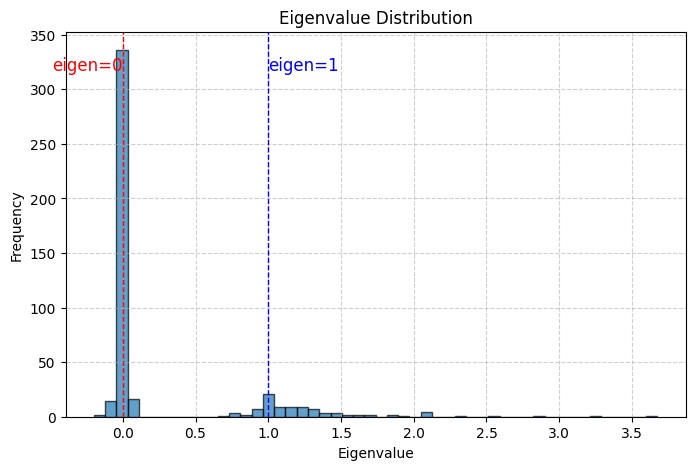

In [2]:


def plot_distribution(eigenvalue_l, bins=50):
    plt.figure(figsize=(8, 5))
    plt.hist(eigenvalue_l, bins=bins, edgecolor='black', alpha=0.7)
    
    # Add vertical dashed lines
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
    plt.axvline(x=1, color='blue', linestyle='--', linewidth=1)
    
    # Add text labels
    plt.text(0, plt.ylim()[1] * 0.9, 'eigen=0', color='red', ha='right', fontsize=12)
    plt.text(1, plt.ylim()[1] * 0.9, 'eigen=1', color='blue', ha='left', fontsize=12)
    
    plt.xlabel('Eigenvalue')
    plt.ylabel('Frequency')
    plt.title('Eigenvalue Distribution')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Example usage
plot_distribution(eigenvalue_l)


In [3]:
from downfolding_methods_pytorch import nelec, norbs, fock_downfolding, Solve_fermionHam, perm_orca2pyscf, LambdaQ
from pyscf import gto, scf, dft
import scipy

def calc_basisNN_inp_file(inp_data):
    elements = inp_data['elements']
    coordinates = inp_data['coordinates']
    atoms = [(elements[i], coordinates[i]) for i in range(len(elements))]
    S = gto.M(
        atom=atoms,  # Atomic symbols and coordinates
        basis="cc-pVDZ"
    ).intor("int1e_ovlp")
    sqrtS = scipy.linalg.sqrtm(S).real
    perm = perm_orca2pyscf(
        atom=atoms,  # Atomic symbols and coordinates
        basis="cc-pVDZ"
    )
    
    proj = inp_data['proj']
    proj = perm @ proj @ perm.T
    proj = sqrtS @ proj @ sqrtS
    
    n_fold = norbs(atom=atoms,basis='sto-3g')
    ham = fock_downfolding(n_fold,('self-defined',-proj),False,atom=atoms, basis='cc-pVDZ')
    E = Solve_fermionHam(ham.Ham_const, ham.int_1bd, ham.int_2bd, nele=nelec(atom=atoms, basis='sto-3G'), method='FCI')[0]
    l = LambdaQ(ham.Ham_const,ham.int_1bd,ham.int_2bd).item()
    return E, l

print(len(data["proj"]))

energy_data['basisNN'] = []
l_data["basisNN"] = []

with tqdm(total=len(data["proj"]), desc="Processing", dynamic_ncols=True) as pbar:
    for proj, elements, pos in zip(data["proj"], data["elements"], data["pos"]):
        inp_data = {'elements': elements, 'coordinates': pos, 'proj': proj}
        basisNN_E, basisNN_l = calc_basisNN_inp_file(inp_data)
        energy_data['basisNN'].append(basisNN_E)
        l_data["basisNN"].append(basisNN_l)
        
        pbar.set_postfix({"basisNN_E": f"{basisNN_E:.6f}"})  # Format to 6 decimals for better readability
        pbar.update(1)

23


Processing: 100%|██████████| 23/23 [00:05<00:00,  3.98it/s, basisNN_E=-2.012283]


In [4]:

# collect other energies
energy_data['CASSCF'] = []
energy_data['HF'] = []
energy_data['B3LYP'] = []
energy_data['sto-3G'] = []
for name in name_l:
    # Load the JSON file
    file_path = os.path.join(folder,'obs',name)
    with open(file_path, "r") as file:
        data = json.load(file)
    energy_data['CASSCF'].append(data['E_opt']['E'])
    energy_data['HF'].append(data['HF']['E'])
    energy_data['B3LYP'].append(data['B3LYP']['E'])
    energy_data['sto-3G'].append(data['sto-3G']['E'])
    energy_data['ccpVDZ'].append(data['ccpVDZ']['E'])


In [5]:
'''
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


num_chains = 25  # Number of chains
chain_length = 4  # Number of H atoms per chain
bond_length_interval = 0.1
lengths = []
for point in range(3, num_chains + 1):
    bond_length = bond_length_interval * point
    lengths.append(bond_length)


# Plot the frequency distribution for each method using KDE
plt.figure(figsize=(10, 6))

numeric_values = np.array([int(name.split('.')[0]) for name in name_l])
sorted_indices = np.argsort(numeric_values)

for method in methods:
    if energy_data[method]:  # Ensure there's data to plot
        plt.plot( np.array(energy_data[method])[sorted_indices], label=method)

# Configure the plot
plt.title("Energy")
plt.xlabel("configuration")
plt.ylabel("Energy (Hartree)")
plt.legend(loc="best")
plt.grid(True)

# Save the plot as a file
output_file = "energy_distribution_smooth.png"
plt.tight_layout()
#plt.savefig(output_file, dpi=300)
plt.show()
plt.close()

print(f"Figure saved as {output_file}")
'''

'\nimport matplotlib.pyplot as plt\nfrom scipy.stats import gaussian_kde\n\n\nnum_chains = 25  # Number of chains\nchain_length = 4  # Number of H atoms per chain\nbond_length_interval = 0.1\nlengths = []\nfor point in range(3, num_chains + 1):\n    bond_length = bond_length_interval * point\n    lengths.append(bond_length)\n\n\n# Plot the frequency distribution for each method using KDE\nplt.figure(figsize=(10, 6))\n\nnumeric_values = np.array([int(name.split(\'.\')[0]) for name in name_l])\nsorted_indices = np.argsort(numeric_values)\n\nfor method in methods:\n    if energy_data[method]:  # Ensure there\'s data to plot\n        plt.plot( np.array(energy_data[method])[sorted_indices], label=method)\n\n# Configure the plot\nplt.title("Energy")\nplt.xlabel("configuration")\nplt.ylabel("Energy (Hartree)")\nplt.legend(loc="best")\nplt.grid(True)\n\n# Save the plot as a file\noutput_file = "energy_distribution_smooth.png"\nplt.tight_layout()\n#plt.savefig(output_file, dpi=300)\nplt.show()\

In [6]:

'''
# Get baseline energy values
baseline_energy = np.array(energy_data['ccpVDZ'])[sorted_indices]

plt.figure(figsize=(10, 6))



# Plot error of other methods relative to 'opt'
for method in methods:
    if method != 'ccpVDZ' and energy_data[method]:  # Ensure there's data to plot
        error = np.array(energy_data[method])[sorted_indices] - baseline_energy
        plt.plot(error, label=f"{method} - opt")

# Configure the plot
plt.title("Energy Error Relative to 'opt' Method")
plt.xlabel("Configuration")
plt.ylabel("Energy Error (Hartree)")
plt.legend(loc="best")
plt.grid(True)

# Save the plot as a file
output_file = "energy_error_plot.png"
plt.tight_layout()
#plt.savefig(output_file, dpi=300)
plt.show()
plt.close()

print(f"Figure saved as {output_file}")
'''

'\n# Get baseline energy values\nbaseline_energy = np.array(energy_data[\'ccpVDZ\'])[sorted_indices]\n\nplt.figure(figsize=(10, 6))\n\n\n\n# Plot error of other methods relative to \'opt\'\nfor method in methods:\n    if method != \'ccpVDZ\' and energy_data[method]:  # Ensure there\'s data to plot\n        error = np.array(energy_data[method])[sorted_indices] - baseline_energy\n        plt.plot(error, label=f"{method} - opt")\n\n# Configure the plot\nplt.title("Energy Error Relative to \'opt\' Method")\nplt.xlabel("Configuration")\nplt.ylabel("Energy Error (Hartree)")\nplt.legend(loc="best")\nplt.grid(True)\n\n# Save the plot as a file\noutput_file = "energy_error_plot.png"\nplt.tight_layout()\n#plt.savefig(output_file, dpi=300)\nplt.show()\nplt.close()\n\nprint(f"Figure saved as {output_file}")\n'

In [7]:

import numpy as np

num_chains = 25  # Number of chains
chain_length = 4  # Number of H atoms per chain
bond_length_interval = 0.1
lengths = []
for point in range(3, num_chains + 1):
    bond_length = bond_length_interval * point
    lengths.append(bond_length)

# Assume `methods`, `energy_data`, and `name_l` are defined elsewhere
numeric_values = np.array([int(name.split('.')[0]) for name in name_l])
sorted_indices = np.argsort(numeric_values)

# Create main figure
fig, ax_main = plt.subplots(figsize=(10, 6))

name_method = {}
for method in methods:
    print(method)
    if method == 'ccpVDZ' or method == 'sto-3G':
        name_method[method] = method
    elif method == 'HF' or method == 'B3LYP':
        name_method[method] = f"Molecule Orbital({method})"
    elif method == 'CASSCF':
        name_method[method] = f"{method} active space"
    elif method == 'basisNN':
        name_method[method] = "ML predicted basis"
    else:
        raise ExceptionType("Error message")
        
        

# Plot main figure (Energy distribution)
for method in methods:
    if  method != 'ccpVDZ' and energy_data[method]:  # Ensure there's data to plot
        i = method_index[method]
        color = colors[i % len(colors)]
        if i == 0:
            ax_main.plot( np.array(energy_data[method])[sorted_indices], label=name_method[method],color = color,alpha=1, linewidth=1.2)
        else:  
            ax_main.plot( np.array(energy_data[method])[sorted_indices], label=name_method[method],color = color,alpha=0.6, linewidth=1.2)
ax_main.plot(np.array(energy_data['ccpVDZ'])[sorted_indices], label='ccpVDZ', color='grey', linestyle='--')

#ax_main.set_title("Ground State Energy with Different Basis Sets")
ax_main.set_xlabel("Configuration", fontsize=25)
ax_main.set_ylabel("Energy (Hartree)", fontsize=25)
ax_main.tick_params(axis='both', which='major', labelsize=23)
ax_main.tick_params(axis='both', which='minor', labelsize=23)
#ax_main.legend(loc="best")
ax_main.grid(False)

# Create an inset axes
ax_inset = fig.add_axes([0.4, 0.6, 0.3, 0.3])  # Adjust inset position and size

# Get baseline energy values
baseline_energy = np.array(energy_data['ccpVDZ'])[sorted_indices]

# Plot error relative to 'opt' inside inset
for method in methods:
    if method != 'ccpVDZ' and energy_data[method]:  # Ensure there's data to plot
        i = method_index[method]
        color = colors[i % len(colors)]
        error = np.array(energy_data[method])[sorted_indices] - baseline_energy
        if i ==0:
            ax_inset.plot( error, label=f"{name_method[method]} - ccpVDZ",color = color,alpha=1, linewidth=2)
        else:
            
            ax_inset.plot( error, label=f"{name_method[method]} - ccpVDZ",color = color,alpha=0.6, linewidth=1.2)

ax_inset.set_title("Basis Error", fontsize=25)
#ax_inset.set_xlabel("Config", fontsize=8)
#ax_inset.set_ylabel("Error (Hartree)", fontsize=8)
ax_inset.tick_params(axis='both', which='major', labelsize=23)
ax_inset.tick_params(axis='both', which='minor', labelsize=23)
#ax_inset.legend(fontsize=8)
#ax_inset.grid(True)

# Save and show the plot
plt.tight_layout()
#plt.show()
plt.savefig("figs/H4_E.pdf",metadata={"TextAsShapes": False})
plt.close()


/tmp/ipykernel_452195/162684616.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


CASSCF
HF
B3LYP
sto-3G
basisNN
ccpVDZ


/tmp/ipykernel_452195/162684616.py:82: UserWarning: Unknown infodict keyword: 'TextAsShapes'. Must be one of {'ModDate', 'Producer', 'Keywords', 'CreationDate', 'Trapped', 'Creator', 'Subject', 'Author', 'Title'}.
  plt.savefig("figs/H4_E.pdf",metadata={"TextAsShapes": False})


In [8]:

# collect other energies

l_data['l_opt'] = []
l_data['CASSCF'] = []
l_data['HF'] = []
l_data['B3LYP'] = []
l_data['sto-3G'] = []
for name in name_l:
    # Load the JSON file
    file_path = os.path.join(folder,'obs',name)
    with open(file_path, "r") as file:
        data = json.load(file)
    l_data['l_opt'].append(data['l_opt']['l'])
    l_data['CASSCF'].append(data['E_opt']['l'])
    l_data['HF'].append(data['HF']['l'])
    l_data['B3LYP'].append(data['B3LYP']['l'])
    l_data['sto-3G'].append(data['sto-3G']['l'])

In [9]:

from scipy.stats import gaussian_kde


num_chains = 25  # Number of chains
chain_length = 4  # Number of H atoms per chain
bond_length_interval = 0.1
lengths = []
for point in range(3, num_chains + 1):
    bond_length = bond_length_interval * point
    lengths.append(bond_length)


# Plot the frequency distribution for each method using KDE
plt.figure(figsize=(10, 6))

numeric_values = np.array([int(name.split('.')[0]) for name in name_l])
sorted_indices = np.argsort(numeric_values)

#l_methods = ['l_opt','E_opt','HF','B3LYP','sto-3G','basisNN']
l_methods = ['CASSCF','HF','B3LYP','sto-3G','basisNN']
for method in l_methods:
    if l_data[method]:  # Ensure there's data to plot
        i = method_index[method]
        color = colors[i % len(colors)]
        if i == 0:
            plt.plot( np.array(l_data[method])[sorted_indices], label=name_method[method],color = color,alpha=1, linewidth=2)
        else:
            plt.plot( np.array(l_data[method])[sorted_indices], label=name_method[method],color = color,alpha=0.6, linewidth=1.2)
            

# Configure the plot
#plt.title("L-1 Norm of Hamiltonians on Different Basis Sets")
plt.xlabel("configuration", fontsize=25)
plt.ylabel("l-1 norm (Hartree)", fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.tick_params(axis='both', which='minor', labelsize=23)
#plt.legend(loc="best",fontsize=20)
#plt.grid(True)

# Save the plot as a file
output_file = "energy_distribution_smooth.pdf"
plt.tight_layout()
#plt.savefig(output_file, dpi=300)
#plt.show()
plt.savefig("figs/H4_l.pdf",metadata={"TextAsShapes": False})
plt.close()

print(f"Figure saved as {output_file}")

Figure saved as energy_distribution_smooth.pdf


/tmp/ipykernel_452195/2468427546.py:45: UserWarning: Unknown infodict keyword: 'TextAsShapes'. Must be one of {'ModDate', 'Producer', 'Keywords', 'CreationDate', 'Trapped', 'Creator', 'Subject', 'Author', 'Title'}.
  plt.savefig("figs/H4_l.pdf",metadata={"TextAsShapes": False})


In [10]:
'''
from matplotlib.patches import Circle
import numpy as np
import matplotlib.gridspec as gridspec

# ======= PREPARE DATA =======
bond_length = 0.74
positions = [i * bond_length for i in range(4)]

#methods = ["CASSCF", "HF", "sto-3G", "basisNN", "ccpVDZ"]
methods = ["CASSCF", "HF", "basisNN", "ccpVDZ"]
numeric_values = np.array([int(name.split('.')[0]) for name in name_l])
sorted_indices = np.argsort(numeric_values)

name_method = {}
for method in methods:
    if method == 'ccpVDZ' or method == 'sto-3G':
        name_method[method] = method
    elif method == 'HF' or method == 'B3LYP':
        name_method[method] = f"Molecule Orbital({method})"
    elif method == 'CASSCF':
        name_method[method] = f"{method} active space"
    elif method == 'basisNN':
        name_method[method] = "ML predicted basis"
    else:
        raise Exception("Unrecognized method")

# ======= CREATE FIGURE AND GRIDSPEC =======
fig = plt.figure(figsize=(8, 10))
gs = gridspec.GridSpec(nrows=3, ncols=1, height_ratios=[1, 2, 2])

# ------- Panel 1: H4 chain diagram -------
ax0 = fig.add_subplot(gs[0])
radius = 0.05
for x in positions:
    circle = Circle((x, 0), radius=radius, edgecolor='black', facecolor='white', linewidth=2)
    ax0.add_patch(circle)
    ax0.text(x, 0.1, 'H', ha='center', va='bottom', fontsize=16)

arrow_y = -0.1
for i in range(len(positions) - 1):
    x0, x1 = positions[i], positions[i + 1]
    ax0.annotate('', xy=(x1, arrow_y), xytext=(x0, arrow_y),
                 arrowprops=dict(arrowstyle='<->', color='black', linewidth=1.5))
    ax0.text((x0 + x1) / 2, arrow_y - 0.05, 'r', ha='center', va='top', fontsize=14)

ax0.set_xlim(-0.5, positions[-1] + 0.5)
ax0.set_ylim(-0.3, 0.4)
ax0.set_aspect('equal')
ax0.axis('off')

# ------- Panel 2: Energy plot -------
ax1 = fig.add_subplot(gs[1])
ax1.tick_params(labelbottom=False)  # hide x-axis labels here

for method in methods:
    if method != 'ccpVDZ' and energy_data[method]:
        i = method_index[method]
        color = colors[i % len(colors)]
        ax1.plot(lengths,np.array(energy_data[method])[sorted_indices],
                 label=name_method[method],
                 color=color, alpha=1 if i == 0 else 0.6, linewidth=2 if i == 0 else 1.2)

baseline_energy = np.array(energy_data['ccpVDZ'])[sorted_indices]
ax1.plot(lengths,baseline_energy, label='ccpVDZ', color='grey', linestyle='--')
ax1.set_ylabel("Energy (Hartree)", fontsize=16)
ax1.tick_params(axis='both', labelsize=14)

# Inset error plot
inset_ax = ax1.inset_axes([0.5, 0.5, 0.4, 0.4])
for method in methods:
    if method != 'ccpVDZ' and energy_data[method]:
        i = method_index[method]
        color = colors[i % len(colors)]
        error = np.array(energy_data[method])[sorted_indices] - baseline_energy
        inset_ax.plot(lengths,error, label=f"{name_method[method]} - ccpVDZ",
                      color=color, alpha=1 if i == 0 else 0.6, linewidth=2 if i == 0 else 1.2)
inset_ax.set_title("Basis Error", fontsize=12)
inset_ax.tick_params(axis='both', labelsize=10)

# ------- Panel 3: L1 norm plot -------
ax2 = fig.add_subplot(gs[2], sharex=ax1)
#l_methods = ['CASSCF', 'HF', 'sto-3G', 'basisNN']
l_methods = ['CASSCF', 'HF','basisNN']
for method in l_methods:
    if l_data[method]:
        i = method_index[method]
        color = colors[i % len(colors)]
        ax2.plot(lengths,np.array(l_data[method])[sorted_indices],
                 label=name_method[method],
                 color=color, alpha=1 if i == 0 else 0.6, linewidth=2 if i == 0 else 1.2)

ax2.set_xlabel("r ($\AA$)", fontsize=16)
ax2.set_ylabel("$\ell_1$ norm (Hartree)", fontsize=16)
ax2.tick_params(axis='both', labelsize=14)

# ------- Layout & Save -------
plt.subplots_adjust(hspace=0.4)  # spacing between plots
plt.savefig("figs/H4_combined_chain_energy_l1.pdf",metadata={"TextAsShapes": False})
plt.show()
'''

<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:1: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_452195/300369541.py:1: SyntaxWarning: invalid escape sequence '\A'
  '''


'\nfrom matplotlib.patches import Circle\nimport numpy as np\nimport matplotlib.gridspec as gridspec\n\n# ======= PREPARE DATA =======\nbond_length = 0.74\npositions = [i * bond_length for i in range(4)]\n\n#methods = ["CASSCF", "HF", "sto-3G", "basisNN", "ccpVDZ"]\nmethods = ["CASSCF", "HF", "basisNN", "ccpVDZ"]\nnumeric_values = np.array([int(name.split(\'.\')[0]) for name in name_l])\nsorted_indices = np.argsort(numeric_values)\n\nname_method = {}\nfor method in methods:\n    if method == \'ccpVDZ\' or method == \'sto-3G\':\n        name_method[method] = method\n    elif method == \'HF\' or method == \'B3LYP\':\n        name_method[method] = f"Molecule Orbital({method})"\n    elif method == \'CASSCF\':\n        name_method[method] = f"{method} active space"\n    elif method == \'basisNN\':\n        name_method[method] = "ML predicted basis"\n    else:\n        raise Exception("Unrecognized method")\n\n# ======= CREATE FIGURE AND GRIDSPEC =======\nfig = plt.figure(figsize=(8, 10))\ng

<>:70: SyntaxWarning: invalid escape sequence '\A'
<>:70: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_452195/3948088738.py:70: SyntaxWarning: invalid escape sequence '\A'
  ax1.set_xlabel("r ($\AA$)", fontsize=16)
/tmp/ipykernel_452195/3948088738.py:83: UserWarning: Unknown infodict keyword: 'TextAsShapes'. Must be one of {'ModDate', 'Producer', 'Keywords', 'CreationDate', 'Trapped', 'Creator', 'Subject', 'Author', 'Title'}.
  plt.savefig("figs/H4_cartoon_error_plot.pdf", metadata={"TextAsShapes": False})


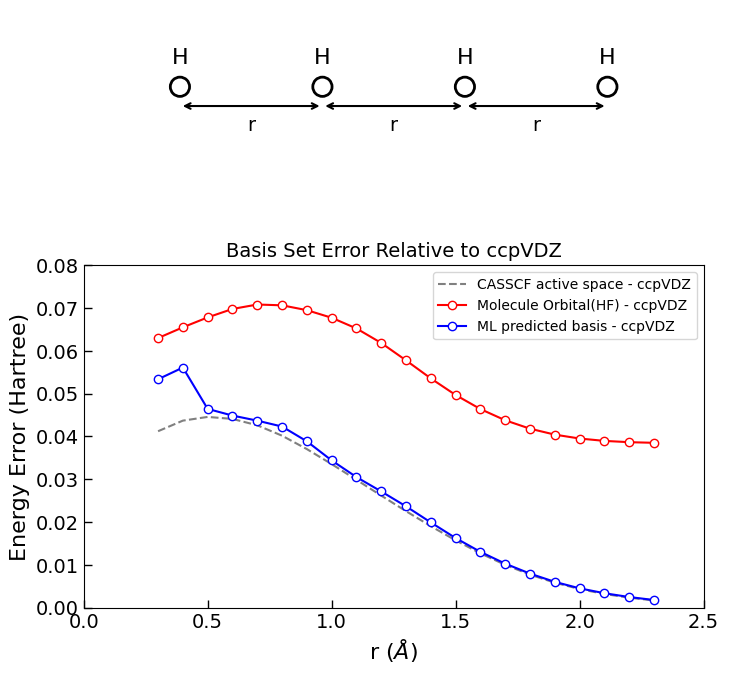

In [11]:
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# ======= PREPARE DATA =======
bond_length = 0.74
positions = [i * bond_length for i in range(4)]

methods = ["CASSCF", "HF", "basisNN", "ccpVDZ"]
mycolor = {"CASSCF":None, "HF":'red', "basisNN":'blue', "ccpVDZ":None}
numeric_values = np.array([int(name.split('.')[0]) for name in name_l])
sorted_indices = np.argsort(numeric_values)

name_method = {}
for method in methods:
    if method == 'ccpVDZ' or method == 'sto-3G':
        name_method[method] = method
    elif method == 'HF' or method == 'B3LYP':
        name_method[method] = f"Molecule Orbital({method})"
    elif method == 'CASSCF':
        name_method[method] = f"{method} active space"
    elif method == 'basisNN':
        name_method[method] = "ML predicted basis"
    else:
        raise Exception("Unrecognized method")

# ======= CREATE FIGURE AND GRIDSPEC =======
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 2])

# ------- Panel 1: Molecule cartoon -------
ax0 = fig.add_subplot(gs[0])
radius = 0.05
for x in positions:
    circle = Circle((x, 0), radius=radius, edgecolor='black', facecolor='white', linewidth=2)
    ax0.add_patch(circle)
    ax0.text(x, 0.1, 'H', ha='center', va='bottom', fontsize=16)

arrow_y = -0.1
for i in range(len(positions) - 1):
    x0, x1 = positions[i], positions[i + 1]
    ax0.annotate('', xy=(x1, arrow_y), xytext=(x0, arrow_y),
                 arrowprops=dict(arrowstyle='<->', color='black', linewidth=1.5))
    ax0.text((x0 + x1) / 2, arrow_y - 0.05, 'r', ha='center', va='top', fontsize=14)

ax0.set_xlim(-0.5, positions[-1] + 0.5)
ax0.set_ylim(-0.3, 0.4)
ax0.set_aspect('equal')
ax0.axis('off')

# ------- Panel 2: Error plot -------
ax1 = fig.add_subplot(gs[1])
baseline_energy = np.array(energy_data['ccpVDZ'])[sorted_indices]

for method in methods:
    if method != 'ccpVDZ' and energy_data[method]:
        i = method_index[method]
        #color = colors[i % len(colors)]
        error = np.array(energy_data[method])[sorted_indices] - baseline_energy
        if method != 'CASSCF':
            ax1.plot(lengths[:-2], error[:-2], label=f"{name_method[method]} - ccpVDZ",
                     color=mycolor[method],marker = 'o', markerfacecolor='white')
        else:
            ax1.plot(lengths[:-2], error[:-2], label=f"{name_method[method]} - ccpVDZ",
                     color='grey', markerfacecolor='white',linestyle='--')
            

ax1.set_title("Basis Set Error Relative to ccpVDZ", fontsize=14)
ax1.set_xlabel("r ($\AA$)", fontsize=16)
ax1.set_ylabel("Energy Error (Hartree)", fontsize=16)
#ax1.tick_params(axis='both', labelsize=14)
plt.tick_params(axis='both', direction='in', length=6, width=1, labelsize=14)
plt.xlim(0, 2.5)
plt.ylim(0, 0.08)
#plt.xticks(np.arange(0, 2.5, 0.5))  # From 0 to 5 with step 1
#plt.yticks(np.arange(0, 0.08, 0.2))   # From 0 to 20 with step 5

ax1.legend()

# ------- Layout & Save -------
plt.subplots_adjust(hspace=0.4)
plt.savefig("figs/H4_cartoon_error_plot.pdf", metadata={"TextAsShapes": False})
plt.show()


/tmp/ipykernel_452195/1711398890.py:17: UserWarning: Unknown infodict keyword: 'TextAsShapes'. Must be one of {'ModDate', 'Producer', 'Keywords', 'CreationDate', 'Trapped', 'Creator', 'Subject', 'Author', 'Title'}.
  fig_legend.savefig("figs/H4_legend_only.pdf",metadata={"TextAsShapes": False})


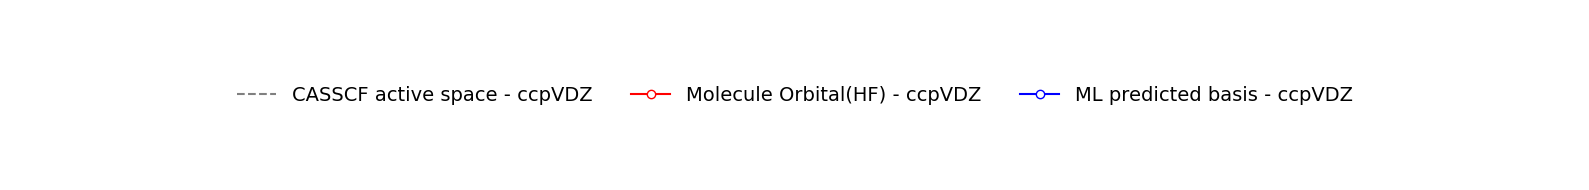

In [12]:
# ======= Legend as a standalone figure =======


# Reuse handles and labels from the main plot
handles, labels = ax1.get_legend_handles_labels()

# Create a separate figure for the legend
fig_legend = plt.figure(figsize=(16, 2))
ax_legend = fig_legend.add_subplot(111)
ax_legend.axis('off')

# Draw the legend
legend = ax_legend.legend(handles, labels, loc='center', ncol=5, fontsize=14, frameon=False)

# Save or show
plt.tight_layout()
fig_legend.savefig("figs/H4_legend_only.pdf",metadata={"TextAsShapes": False})
plt.show()


In [13]:
'''
plt.figure(figsize=(8,6))

# Different colors for different methods
colors = plt.cm.tab10(np.linspace(0, 1, len(l_methods)))

for idx, method in enumerate(l_methods):
    l_values = np.array(l_data[method])[sorted_indices]
    accuracy = np.array(energy_data[method])[sorted_indices] - baseline_energy
    #print(method,np.mean(accuracy),np.mean(l_values))
    print(method,accuracy[5],l_values[5])
    
    plt.scatter(l_values[5:6], accuracy[5:6],s=100, marker='x',color=colors[idx], label=name_method[method])

# Add labels and legend
plt.yscale('log')
plt.xlabel('l-1 norm')
plt.ylabel('Basis Error of Energy (Hatree)')
plt.title('Accuracy vs lambda_Q Tradeoff for Different Basis Sets')
#plt.legend(fontsize=24)
plt.grid(True)
plt.tight_layout()
#plt.show()
plt.savefig("figs/E_l.pdf")
'''

'\nplt.figure(figsize=(8,6))\n\n# Different colors for different methods\ncolors = plt.cm.tab10(np.linspace(0, 1, len(l_methods)))\n\nfor idx, method in enumerate(l_methods):\n    l_values = np.array(l_data[method])[sorted_indices]\n    accuracy = np.array(energy_data[method])[sorted_indices] - baseline_energy\n    #print(method,np.mean(accuracy),np.mean(l_values))\n    print(method,accuracy[5],l_values[5])\n    \n    plt.scatter(l_values[5:6], accuracy[5:6],s=100, marker=\'x\',color=colors[idx], label=name_method[method])\n\n# Add labels and legend\nplt.yscale(\'log\')\nplt.xlabel(\'l-1 norm\')\nplt.ylabel(\'Basis Error of Energy (Hatree)\')\nplt.title(\'Accuracy vs lambda_Q Tradeoff for Different Basis Sets\')\n#plt.legend(fontsize=24)\nplt.grid(True)\nplt.tight_layout()\n#plt.show()\nplt.savefig("figs/E_l.pdf")\n'